In [1]:
import pandas as pd
import numpy as np
from sklearn import ensemble, grid_search, model_selection, cross_validation, metrics, linear_model
import xgboost
from matplotlib import pyplot as plt
import seaborn
import math
%matplotlib inline

/Users/maks/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/maks/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df = pd.read_csv('Train.csv')

In [3]:
df.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
0,0,2011-1,121,1.0,3,52,2,1,30.0,0.0,...,0,0,0,0,0,0,0,0,0,3090000
1,1,2011-1,58,1.0,6,101,3,1,5.0,NaN,...,0,0,0,0,0,0,0,0,0,15372000
2,2,2011-1,530,0.0,11,71,3,0,30.0,NaN,...,0,0,0,0,0,0,0,0,0,10067000
3,3,2011-1,448,NaN,5,36,1,1,15.0,0.0,...,0,0,0,0,0,0,0,0,0,3159000
4,4,2011-1,404,2.0,3,215,6,2,20.0,1.0,...,0,0,0,0,0,0,0,0,0,13816000


In [4]:
df.shape

(100000, 25)

In [5]:
df.describe()

,id,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,...,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13,price
count,100000.000000,100000.000000,69896.000000,100000.000000,100000.000000,100000.00000,100000.000000,95047.000000,69943.000000,100000.000000,...,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,1.000000e+05
mean,49999.500000,334.506830,0.539015,5.280490,52.108100,2.11278,0.402810,21.799846,0.497762,2.480110,...,0.004090,0.001460,0.000650,0.00801,0.008320,0.001800,0.000290,0.001420,0.000220,5.329125e+06
std,28867.657797,194.178711,0.578554,3.947259,17.433424,0.82522,0.550869,8.342282,0.499999,1.945282,...,0.063823,0.038182,0.025487,0.08914,0.090834,0.042388,0.017027,0.037656,0.014831,4.669177e+06
min,0.000000,0.000000,0.000000,1.000000,29.000000,1.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,3.940000e+05
25%,24999.750000,165.000000,0.000000,2.000000,40.000000,1.00000,0.000000,15.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,2.673000e+06
50%,49999.500000,334.000000,0.000000,4.000000,52.000000,2.00000,0.000000,25.000000,0.000000,2.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,4.169500e+06
75%,74999.250000,503.000000,1.000000,7.000000,60.000000,3.00000,1.000000,30.000000,1.000000,4.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,6.414000e+06
max,99999.000000,671.000000,2.000000,25.000000,217.000000,6.00000,2.000000,30.000000,1.000000,11.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.104980e+08


In [6]:
df = df.drop('id', axis=1)
df = df.drop('date', axis=1)
data = df

In [7]:
labels = data.price
data = data.drop('price', axis=1)

In [8]:
def calculate_means(numeric_data):
    means = np.zeros(numeric_data.shape[1])
    for j in range(numeric_data.shape[1]):
        to_sum = numeric_data.iloc[:,j]
        indices = np.nonzero(~numeric_data.iloc[:,j].isnull())[0]
        correction = np.amax(to_sum[indices])
        to_sum /= correction
        for i in indices:
            means[j] += to_sum[i]
        means[j] /= indices.size
        means[j] *= correction
        return pd.Series(means, numeric_data.columns)

In [9]:
X = data
means = calculate_means(data)
for col, mean in zip(data.columns, means):
    X[col] = data[col].fillna(mean)

In [10]:
X.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,121,1.0,3,52,2,1,30.0,0.0,2,0,...,0,0,0,0,0,0,0,0,0,0
1,58,1.0,6,101,3,1,5.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,530,0.0,11,71,3,0,30.0,0.0,8,0,...,0,0,0,0,0,0,0,0,0,0
3,448,0.0,5,36,1,1,15.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,404,2.0,3,215,6,2,20.0,1.0,2,0,...,0,0,0,0,0,0,0,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a0d696950>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a1a9a75d0>]], dtype=object)

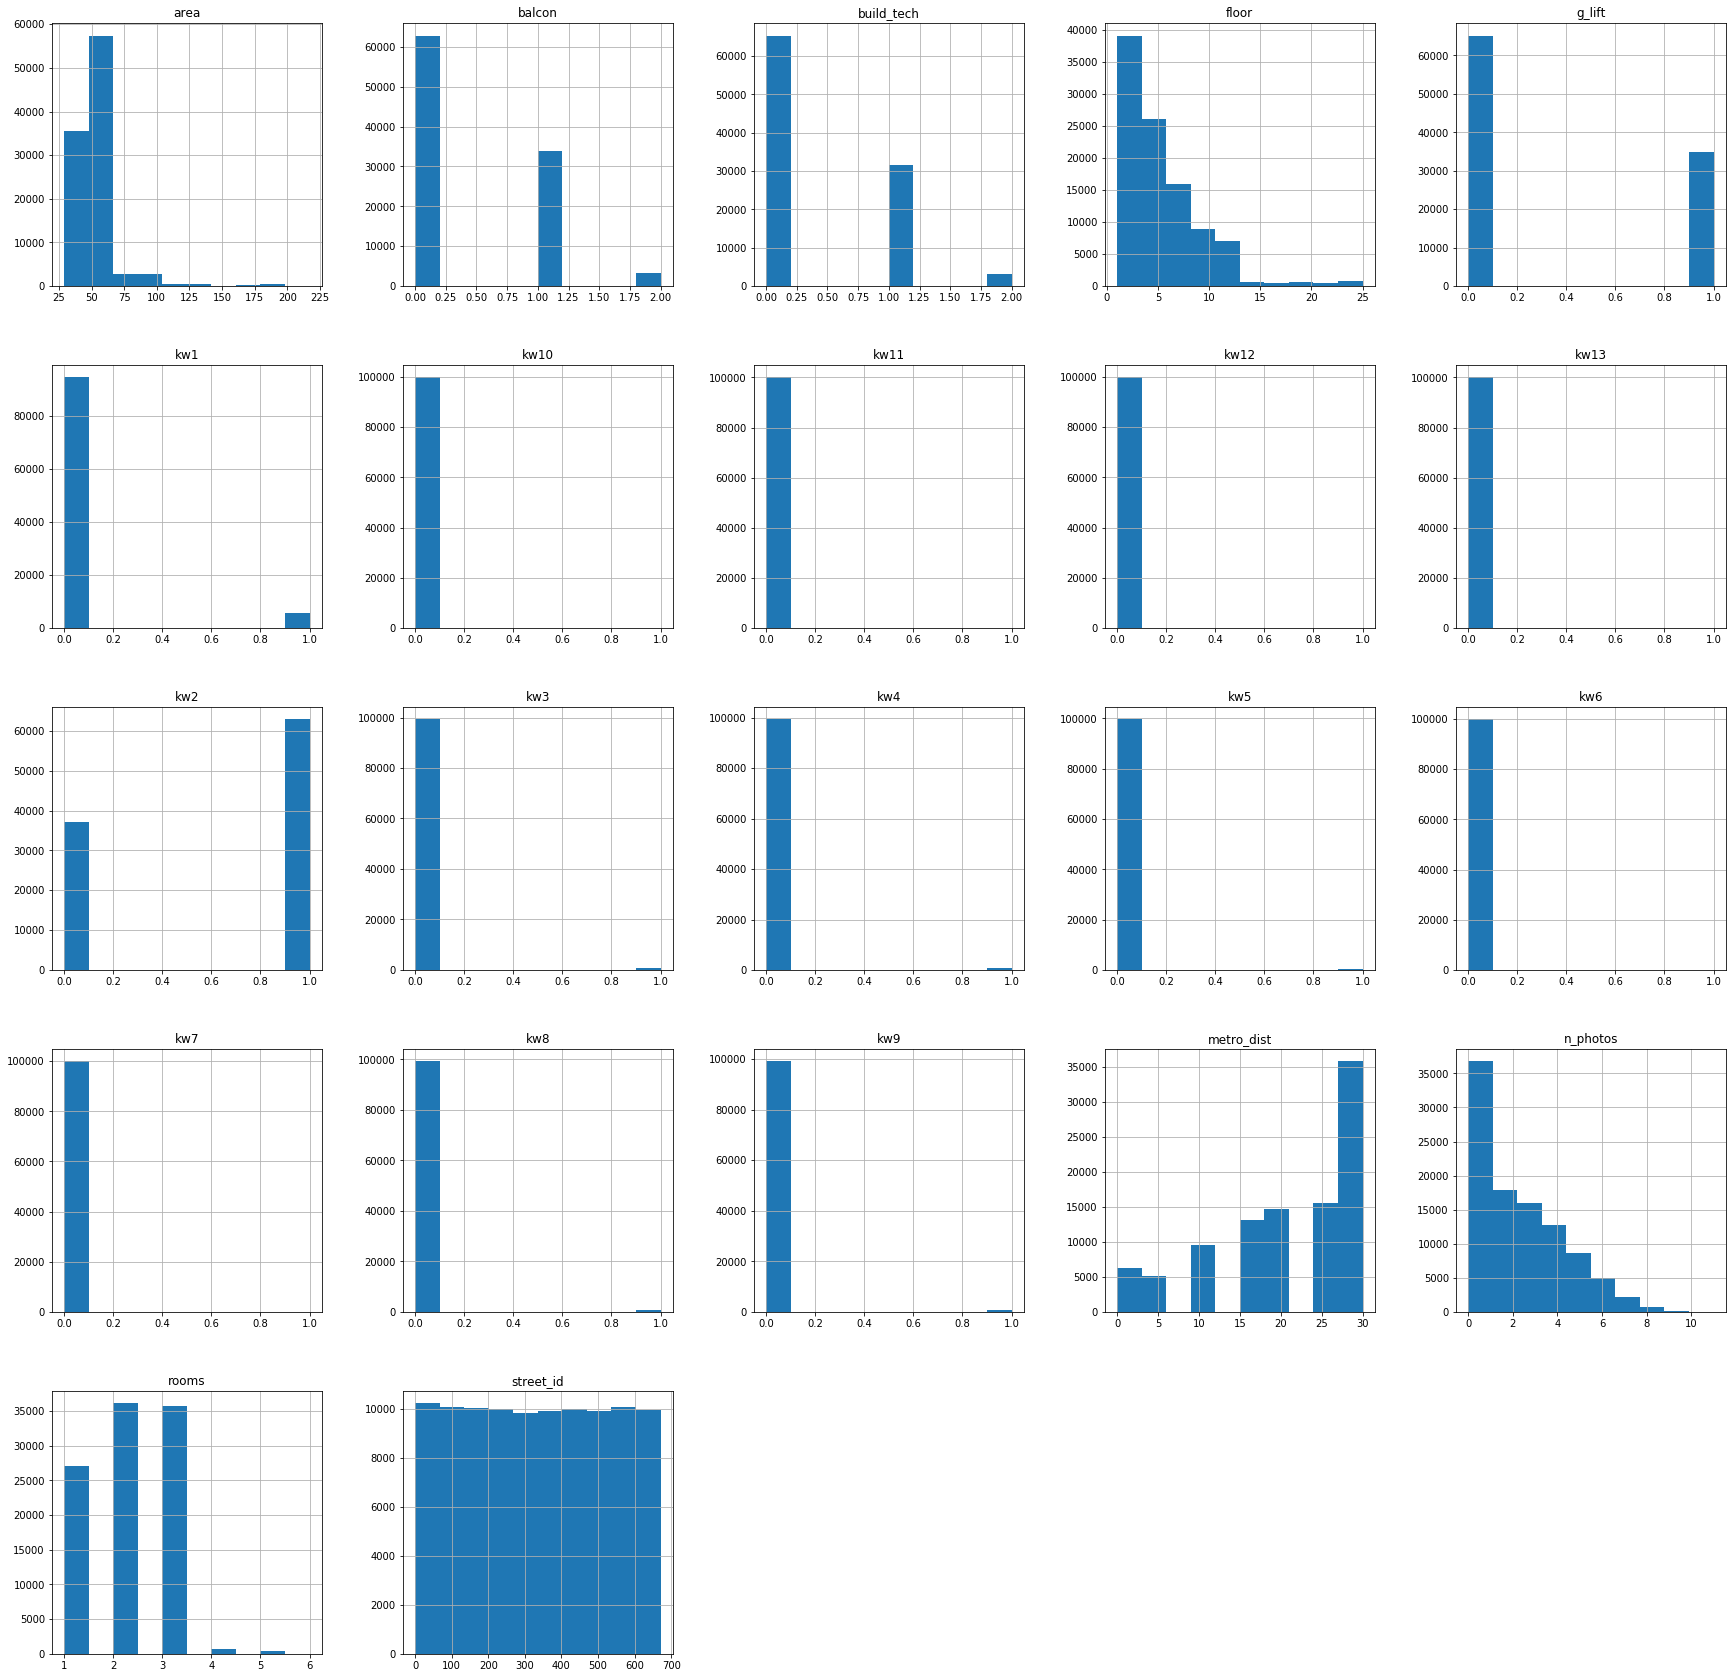

In [11]:
X.hist(figsize=(30, 30), bins=10)

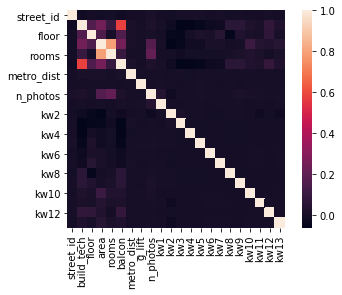

In [12]:
seaborn.heatmap(X.corr(), square=True)

In [13]:
for col in df.columns:
    print col, df.corr()[col]['price']

street_id -0.0195257745447
build_tech 0.36316367917
floor 0.218026646382
area 0.650133966026
rooms 0.35401784671
balcon 0.280249585588
metro_dist -0.0998346023678
g_lift 0.00390788150976
n_photos 0.176103654755
kw1 0.0157813990171
kw2 -0.0727822758016
kw3 -0.0496460708412
kw4 -0.0271749296918
kw5 -0.0134116139469
kw6 0.0184910104313
kw7 0.00825733992244
kw8 -0.00460828088213
kw9 0.0034350624816
kw10 0.0919012011533
kw11 0.0543482192472
kw12 0.0457945068326
kw13 0.0426991377152
price 1.0


In [14]:
for i in range(1, 14):
    print i, 
    print len(df[df['kw' + str(i)] == 0]),
    print len(df[df['kw' + str(i)] == 1])
print 'l', len(df[df['g_lift'] == 0.0]), len(df[df['g_lift'] == 1.0])
print 'l', len(X[X['g_lift'] == 0.0]), len(X[X['g_lift'] == 1.0])

1 94346 5654
2 37116 62884
3 99263 737
4 99381 619
5 99591 409
6 99854 146
7 99935 65
8 99199 801
9 99168 832
10 99820 180
11 99971 29
12 99858 142
13 99978 22
l 35128 34815
l 65185 34815


In [15]:
X.columns

Index([u'street_id', u'build_tech', u'floor', u'area', u'rooms', u'balcon',
       u'metro_dist', u'g_lift', u'n_photos', u'kw1', u'kw2', u'kw3', u'kw4',
       u'kw5', u'kw6', u'kw7', u'kw8', u'kw9', u'kw10', u'kw11', u'kw12',
       u'kw13'],
      dtype='object')

In [38]:
col = X.columns
col

Index([u'street_id', u'build_tech', u'floor', u'area', u'rooms', u'balcon',
       u'metro_dist', u'g_lift', u'n_photos', u'kw1', u'kw2', u'kw3', u'kw4',
       u'kw5', u'kw6', u'kw7', u'kw8', u'kw9', u'kw10', u'kw11', u'kw12',
       u'kw13'],
      dtype='object')

In [39]:
XX = X.drop('n_photos', axis=1)

In [40]:
XX['area2'] = XX['area'] * XX['area']

In [34]:
res = np.zeros(100000)
for i in ['kw' + str(k) for k in range(1, 14)]:
    for j in ['kw' + str(k) for k in range(1, 14)]:
        if i != j:
            XX[i + j] = XX[i] + XX[j]

In [41]:
res = np.zeros(100000)
for i in ['kw' + str(j) for j in range(1, 14)]:
    res += X[i]

In [42]:
XX['kw'] = res

In [43]:
XX.columns

Index([u'street_id', u'build_tech', u'floor', u'area', u'rooms', u'balcon',
       u'metro_dist', u'g_lift', u'kw1', u'kw2', u'kw3', u'kw4', u'kw5',
       u'kw6', u'kw7', u'kw8', u'kw9', u'kw10', u'kw11', u'kw12', u'kw13',
       u'area2', u'kw'],
      dtype='object')

###### Xtrain, Xtest, trainLabels, testLabels = cross_validation.train_test_split(XX, labels, test_size = 0.5, random_state = 0)

In [45]:
Xtrain.columns

Index([u'street_id', u'build_tech', u'floor', u'area', u'rooms', u'balcon',
       u'metro_dist', u'g_lift', u'kw1', u'kw2', u'kw3', u'kw4', u'kw5',
       u'kw6', u'kw7', u'kw8', u'kw9', u'kw10', u'kw11', u'kw12', u'kw13',
       u'area2', u'kw'],
      dtype='object')

In [58]:
estimator = xgboost.XGBRegressor(max_depth=5, n_estimators=2000, learning_rate=0.1, min_child_weight=3, n_jobs=8)

In [59]:
estimator.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 3,
 'missing': None,
 'n_estimators': 2000,
 'n_jobs': 8,
 'nthread': None,
 'objective': 'reg:linear',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1}

In [60]:
%%time
estimator.fit(Xtrain, trainLabels)

CPU times: user 2min 1s, sys: 271 ms, total: 2min 1s
Wall time: 2min 2s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=3, missing=None, n_estimators=2000,
       n_jobs=8, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [61]:
pred = estimator.predict(Xtest)

In [64]:
metrics.mean_absolute_error(pred, testLabels)

876264.94382387691

In [192]:
dff = pd.read_csv('Test.csv')

In [193]:
dff.head()

,id,date,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,100000,2012-3,487,NaN,3,52,2,1,25.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,100001,2012-3,166,1.0,2,61,3,1,15.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,100002,2012-3,59,0.0,1,33,1,0,15.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,100003,2012-3,428,NaN,4,51,2,1,15.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,100004,2012-3,572,1.0,4,60,3,0,15.0,1.0,...,0,0,0,0,0,0,0,0,0,0


In [194]:
dataf = dff.drop(['id', 'date'], axis=1)

In [195]:
Xt = dataf
means = calculate_means(dataf)
for col, mean in zip(dataf.columns, means):
    Xt[col] = dataf[col].fillna(mean)

In [196]:
Xt.head()

,street_id,build_tech,floor,area,rooms,balcon,metro_dist,g_lift,n_photos,kw1,...,kw4,kw5,kw6,kw7,kw8,kw9,kw10,kw11,kw12,kw13
0,487,0.0,3,52,2,1,25.0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,166,1.0,2,61,3,1,15.0,0.0,7,0,...,0,0,0,0,0,0,0,0,0,0
2,59,0.0,1,33,1,0,15.0,0.0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,428,0.0,4,51,2,1,15.0,0.0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,572,1.0,4,60,3,0,15.0,1.0,6,0,...,0,0,0,0,0,0,0,0,0,0


In [189]:
estimator = xgboost.XGBRegressor(learning_rate=0.05, n_estimators=7000, max_depth=5)

In [190]:
%%time
estimator.fit(X, labels)

CPU times: user 12min 44s, sys: 690 ms, total: 12min 45s
Wall time: 12min 46s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=7000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [197]:
pred = estimator.predict(Xt)

In [196]:
for i, p in enumerate(pred):
    pred[i] = math.ceil(p)

In [198]:
write = pd.DataFrame({
    'id': dff.id,
    'price': pred
})

write.to_csv('submission.csv', header=True, index=False, encoding='utf-8')